In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.diagnostic import het_white

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import yfinance as yf

# tech_stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
# bank_stocks = ['WFC', 'BAC', 'C']
# commodity_futures = ['GC=F', 'SI=F', 'CL=F']
# cryptocurrencies = ['BTC-USD', 'ETH-USD', 'XRP-USD']
# currencies = ['EURUSD=X', 'JPY=X', 'GBPUSD=X']
# us_treasuries = ['^TNX', '^IRX', '^TYX']
# indices = ['^RUT', '^IXIC', '^GSPC', '^DJI']

# start = '2012-05-16'
# end = '2022-05-16'

# data = yf.download(tech_stocks + bank_stocks + commodity_futures + cryptocurrencies + currencies + us_treasuries + indices + etfs, start=start, end=end)

# data.to_csv('./price_data')

# min_max_scaler = preprocessing.MinMaxScaler()
# X_scaled = min_max_scaler.fit_transform(X)
# X_scaled = pd.DataFrame(X_scaled)

In [3]:
prices = pd.read_csv('./price_data.csv', index_col=0).drop('SHY', axis = 1)
prices.index = pd.to_datetime(prices.index)
prices.tail()

,Apple,Amazon,BofA,Bitcoin,Citi,Oil,Ethereum,Euro,Pound,Gold,...,Silver,Wells_Fargo,Ripple,DJIA,S&P500,T_Bill_13W,Nasdaq,Russell2000,Bond_10Y,Bond_30Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-09,152.059998,2175.780029,36.369999,30296.953125,49.889999,103.089996,2245.430420,1.053219,1.232666,1857.099976,...,21.782000,43.959999,0.492940,32245.699219,3991.239990,0.800,11623.250000,1762.079956,3.079,3.208
2022-05-10,154.509995,2177.179932,35.759998,31022.906250,48.750000,99.760002,2343.510986,1.056580,1.233882,1839.900024,...,21.389999,43.080002,0.513626,32160.740234,4001.050049,0.878,11737.669922,1761.790039,2.993,3.130
2022-05-11,146.500000,2107.439941,35.570000,28936.355469,47.660000,105.709999,2072.108643,1.053297,1.230921,1852.599976,...,21.549999,42.570000,0.413376,31834.109375,3935.179932,0.883,11364.240234,1718.140015,2.921,3.044
2022-05-12,142.559998,2138.610107,35.070000,29047.751953,46.560001,106.129997,1961.701538,1.051248,1.223421,1823.800049,...,20.757000,41.810001,0.385206,31730.300781,3930.080078,0.905,11370.959961,1739.380005,2.817,2.985
2022-05-13,147.110001,2261.100098,35.169998,29283.103516,47.639999,110.489998,2014.418213,1.037958,1.220614,1807.400024,...,20.983999,42.639999,0.423417,32196.660156,4023.889893,0.943,11805.000000,1792.670044,2.935,3.093


In [4]:
target = 'Gold'

X = prices.dropna().drop(target, axis = 1)
y = prices.dropna()[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [5]:
def model_summary_to_dataframe(model):
    '''takes a model and transforms it into a dataframe'''
    pvals = model.pvalues.round(4)
    tvals = model.tvalues.round(3)
    coef = model.params.round(4)
    conf_lower = model.conf_int()[0].round(3)
    conf_upper = model.conf_int()[1].round(3)

    results_df = pd.DataFrame({"P>|t|":pvals,
                               "t":tvals,
                               "coef":coef,
                               "conf_lower":conf_lower,
                               "conf_upper":conf_upper
                                })

    results_df = results_df[["coef", "t", "P>|t|","conf_lower","conf_upper"]]
    return results_df

###### Knowing that our target variable is Gold, we can put together a "kitchen sink" model with all of our explanatory variables (features) and use that as our base model to iteratively refine. Straightaway, we can use the model coefficients produced using scikit-learn's LinearRegression method to arrive at a preliminary sense of feature importance. 

In [6]:
model = sm.OLS(y_train, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Gold   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.825e+04
Date:                Mon, 15 Aug 2022   Prob (F-statistic):                        0.00
Time:                        14:39:50   Log-Likelihood:                         -3582.0
No. Observations:                 736   AIC:                                      7208.
Df Residuals:                     714   BIC:                                      7309.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Apple          -1.0179      0.385     -2.641      0.008      -1.774      -0.261
Amazon         -0.0209      0.013     -1.548      0.122      -0.047       0.006
BofA            3.6814      1.414      2.604      0.009       0.906       6.457
Bitcoin         0.0011      0.000      2.397      0.017       0.000       0.002
Citi           -1.8586      0.544     -3.418      0.001      -2.926      -0.791
Oil             0.9525      0.232      4.114      0.000       0.498       1.407
Ethereum       -0.0458      0.009     -5.369      0.000      -0.063      -0.029
Euro          363.4762     79.230      4.588      0.000     207.924     519.028
Pound         275.0965     69.667      3.949      0.000     138.320     411.873
Google         -0.1118      0.022     -5.024      0.000      -0.156      -0.068
Yen             4.6161      0.531      8.699      0.000       3.574       5.658
Microsoft       2.5929      0.329      7.870      0.000       1.946       3.240
Silver         27.5136      1.063     25.873      0.000      25.426      29.601
Wells_Fargo    -6.3822      0.772     -8.268      0.000      -7.898      -4.867
Ripple         16.3588      5.924      2.762      0.006       4.729      27.989
DJIA           -0.0012      0.007     -0.179      0.858      -0.014       0.012
S&P500          0.3812      0.076      5.043      0.000       0.233       0.530
T_Bill_13W    -32.4569      6.625     -4.899      0.000     -45.463     -19.451
Nasdaq         -0.0821      0.017     -4.812      0.000      -0.116      -0.049
Russell2000    -0.1390      0.050     -2.772      0.006      -0.237      -0.041
Bond_10Y       59.5307     20.729      2.872      0.004      18.833     100.228
Bond_30Y     -176.1482     23.964     -7.351      0.000    -223.196    -129.100
==============================================================================
Omnibus:                        6.272   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.515
Skew:                          -0.167   Prob(JB):                       0.0385
Kurtosis:                       3.318   Cond. No.                     3.04e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### There are several metrics that are calculated in order to effectively score a multiple regression model:
    * Coefficient of Determination (R-sqared value)/Adjusted R-squared value
    * MSE/RMSE

In [7]:
y_pred = model.predict(X_test)

print('  R2:   ', r2_score(y_test, y_pred).round(3), '\n'
      ' MSE:', mean_squared_error(y_test, y_pred).round(3), '\n'
      'RMSE:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - len(X.columns) - 1)
print("Adj. R2: ", adj_r2.round(3))

  R2:    0.981 
 MSE: 1257.155 
RMSE:   35.456
Adj. R2:  0.98


In [8]:
df = model_summary_to_dataframe(model)
df['P>|t|'] = pd.to_numeric(df['P>|t|'])
df[df['P>|t|'] > 0.05]

,coef,t,P>|t|,conf_lower,conf_upper
Amazon,-0.0209,-1.548,0.1221,-0.047,0.006
DJIA,-0.0012,-0.179,0.8576,-0.014,0.012


###### Kitchen sink model replicated using scikit-learn

In [9]:
model = LinearRegression(fit_intercept=True).fit(X_train, y_train)

weights = model.coef_

feature = []
weight = []

for i, v in enumerate(weights):
    feature.append(i)
    weight.append(f'{v.round(4)}')
    
df = pd.DataFrame({'feature': feature,
                   'weight': weight}).sort_values(by='weight', ascending=False)

df.feature = X.columns

df.weight = pd.to_numeric(df.weight)

df.sort_values(by='weight', ascending=False).reset_index(drop=True)

,feature,weight
0,BofA,226.9053
1,Bitcoin,129.9877
2,Apple,29.9999
3,Amazon,25.6363
4,Citi,1.6705
5,Oil,1.2564
6,Ethereum,1.2244
7,Euro,0.3238
8,Pound,0.0052
9,Google,0.0006


In [10]:
y_pred = model.predict(X_test)

print('  R2:   ', r2_score(y_test, y_pred).round(3), '\n'
      ' MSE:', mean_squared_error(y_test, y_pred).round(3), '\n'
      'RMSE:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - len(X.columns) - 1)
print("Adj. R2:", adj_r2.round(3))

  R2:    0.984 
 MSE: 1039.121 
RMSE:   32.235
Adj. R2: 0.984


###### Visualizing correlation for every possible combination of variables in our feature set; In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.

<AxesSubplot:>

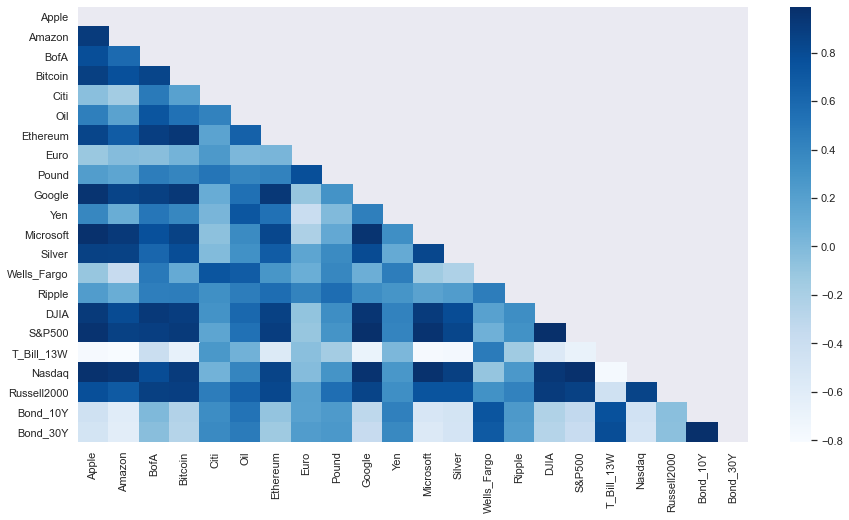

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
corr = X.corr()
mask = np.triu(corr)
sns.heatmap(corr, cmap="Blues", mask=mask)

###### Making predictions with our model using our test set helps us derive a sense of how error-prone our model is; these residuals can be used to create several types of diagnostic visualizations that will help us evaluate our model(s), namely:

    * QQ-Plot
    * Residual Distribution Plot
    * Box Plot of Residuals
    * Residual Plot
    
###### A fundamental assumption is that the residuals (or “errors”) are random: some big, some some small, some positive, some negative, but overall, the errors are normally distributed around a mean of zero. Anything other than normally distributed residuals indicates a serious problem with the linear model.

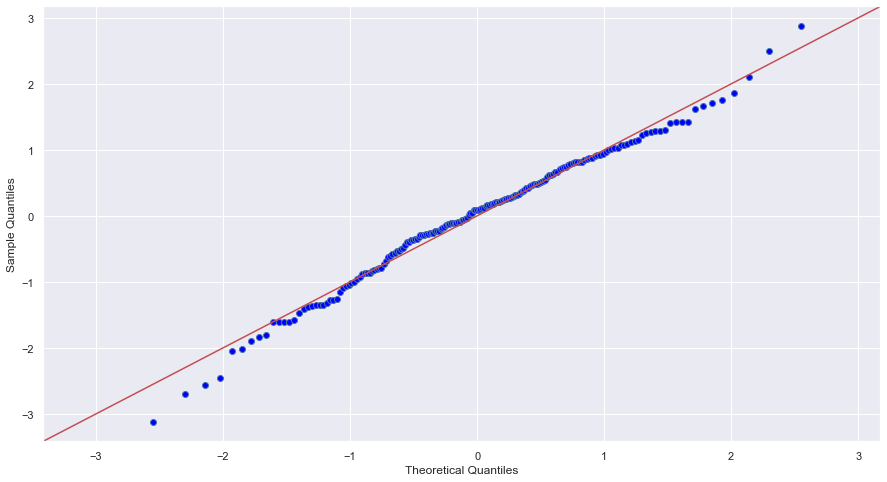

In [12]:
y_pred = model.predict(X_test)

residuals = y_test - y_pred

fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

###### A slightly more useful approach for assessing normality is to compare the kernel density estimate with the curve for the corresponding normal curve. To do this, we generate the normal curve that has the same mean and standard deviation as our observed residual and plot it on top of our residual.

###### By plotting the residuals as a kernel density plot overlaid onto the normal curve with the same mean and standard deviation, we can gauge whether the residuals from our model fit a normal distribution.

<AxesSubplot:xlabel='Gold', ylabel='Density'>

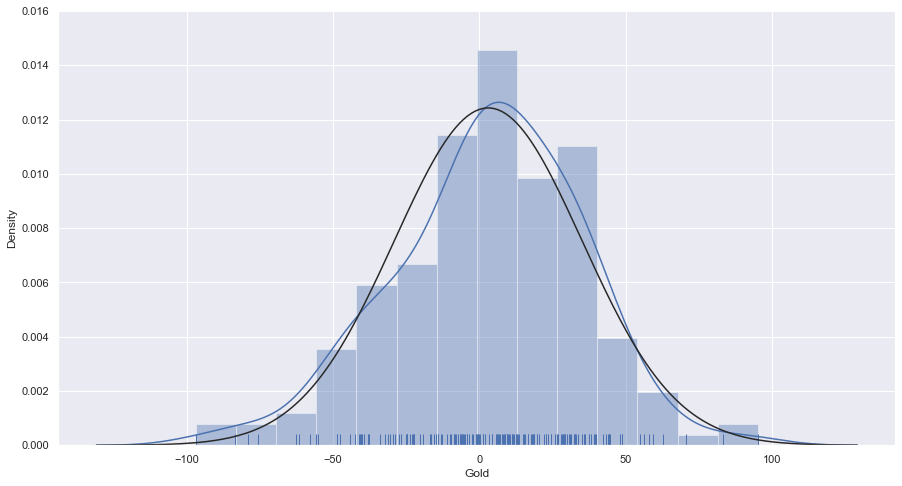

In [13]:
sns.distplot(residuals, fit=stats.norm, rug = True)

###### A boxplot is often better when the residuals are highly non-normal. Here we see a reasonable distribution with the mean close to the median (indicating symmetry).

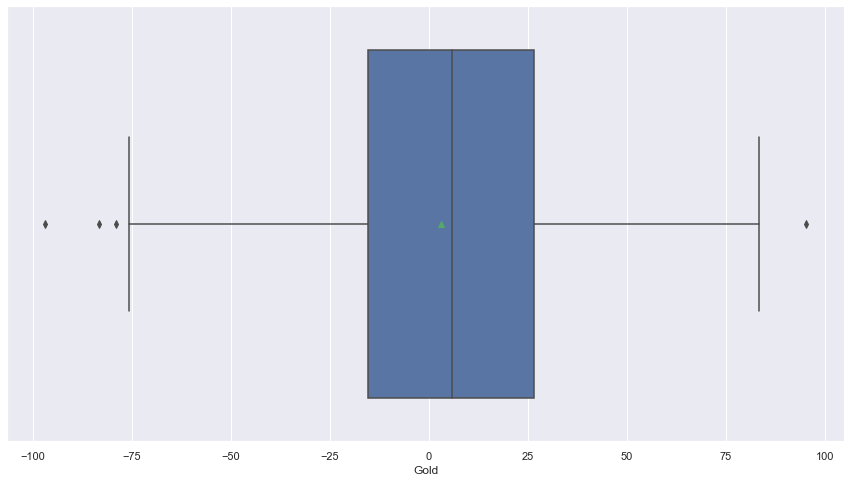

In [14]:
sns.boxplot(residuals, showmeans = True);

###### Plotting our model's predictions against its residuals using seaborn's residual plot method

<AxesSubplot:ylabel='Gold'>

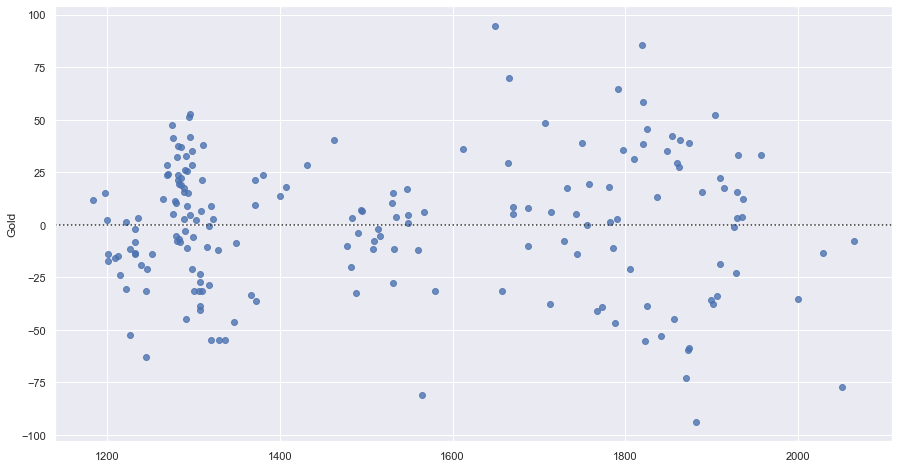

In [15]:
sns.residplot(y_pred, residuals)

###### The most useful way to plot the residuals, though, is with your predicted values on the x-axis and your residuals on the y-axis.

###### (I am presenting residuals here as standardized residuals, which means every residual plot you look at with any model is on the same standardized y-axis.)

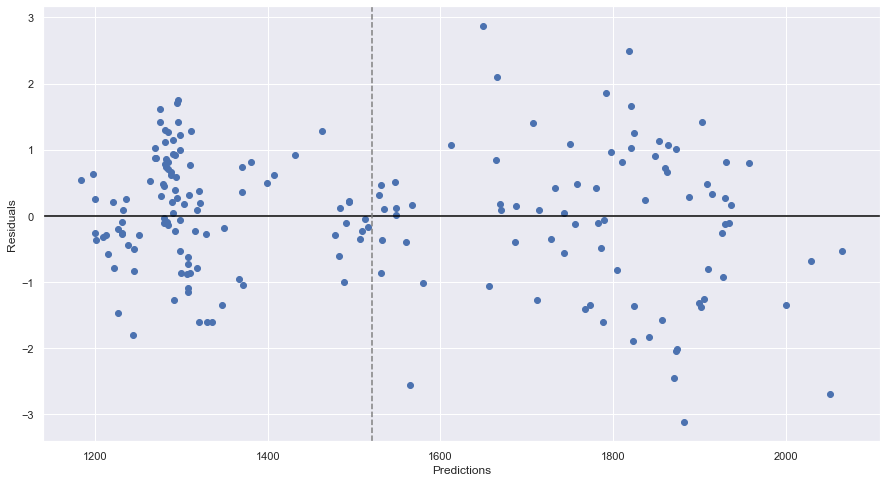

In [16]:
residuals = y_test - y_pred

residuals = (residuals - residuals.mean()) / residuals.std()

plt.scatter(y_pred, residuals)

plt.axhline(0, color='black')
plt.axvline(y_test.mean(), color='grey', ls='--')

plt.xlabel('Predictions')
plt.ylabel('Residuals')

plt.show()

###### A plot of our model's predictions against the actual test set suggests that our model is accurate; there’s a strong correlation between the model’s predictions and its actual results.

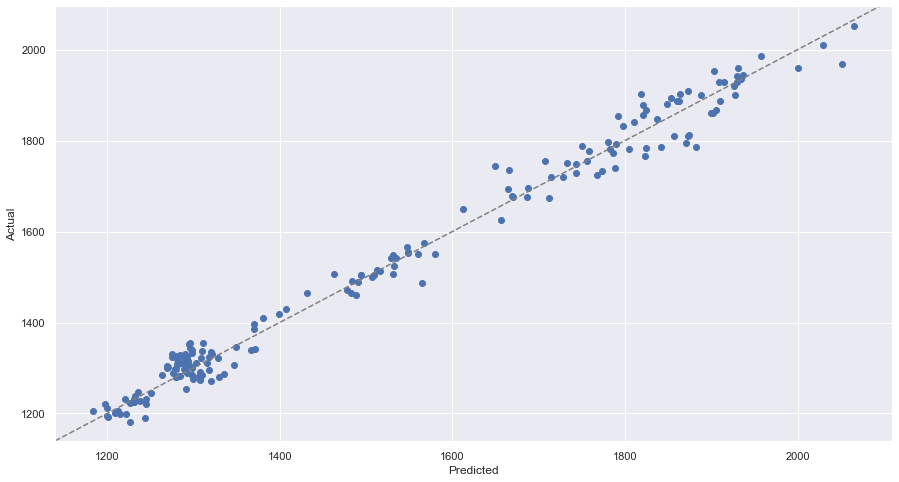

In [17]:
plt.scatter(y_pred, y_test)
# plt.axhline(0, color='grey', ls='--')
# plt.axvline(y_test.mean(), color='grey', ls='--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='grey', scalex=False, scaley=False)
plt.show()

In [18]:
y_pred = model.predict(X_test)

print('  R2:   ', r2_score(y_test, y_pred).round(3), '\n'
      ' MSE:', mean_squared_error(y_test, y_pred).round(3), '\n'
      'RMSE:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - len(X.columns) - 1)
print("Adj. R2:", adj_r2.round(3))

  R2:    0.984 
 MSE: 1039.121 
RMSE:   32.235
Adj. R2: 0.984


###### A variance inflation factor (VIF) provides a measure of multicollinearity among the independent variables in a multiple regression model.
###### Detecting multicollinearity is important because while multicollinearity does not reduce the explanatory power of the model, it does reduce the statistical significance of the independent variables. 
###### A large variance inflation factor (VIF) on an independent variable indicates a highly collinear relationship to the other variables that should be considered or adjusted for in the structure of the model and selection of independent variables.

In [19]:
df = pd.DataFrame({})

df["feature"] = X_train.columns
df["VIF"] = [vif(X_train.values, i) for i in range(len(X_train.columns))]

df = df.sort_values(by='VIF', ascending=False)

df[df.VIF > df.VIF.mean()].set_index('feature')

,VIF
feature,
S&P500,44311.193237
DJIA,24784.983361
Nasdaq,20425.093251
Pound,6017.353751
Euro,5960.665531


In [20]:
Microsoft = X_train[['Microsoft']]
Nasdaq = X_train[['Nasdaq']]
Silver = X_train[['Silver']]
Bond_30Y = X_train[['Bond_30Y']]
Gold = y_train

model = ols('Gold ~ Microsoft + Nasdaq + Silver + Bond_30Y',
            data = X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     6450.
Date:                Mon, 15 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:39:51   Log-Likelihood:                -3790.2
No. Observations:                 736   AIC:                             7590.
Df Residuals:                     731   BIC:                             7614.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1301.4937     13.298     97.874      0.000    1275.388    1327.600
Microsoft      3.9870      0.108     36.909      0.000       3.775       4.199
Nasdaq        -0.0955      0.003    -28.140      0.000      -0.102      -0.089
Silver        41.0659      0.898     45.726      0.000      39.303      42.829
Bond_30Y    -116.8642      3.288    -35.541      0.000    -123.320    -110.409
==============================================================================
Omnibus:                        7.565   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.726
Skew:                           0.246   Prob(JB):                       0.0210
Kurtosis:                       2.901   Cond. No.                     8.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

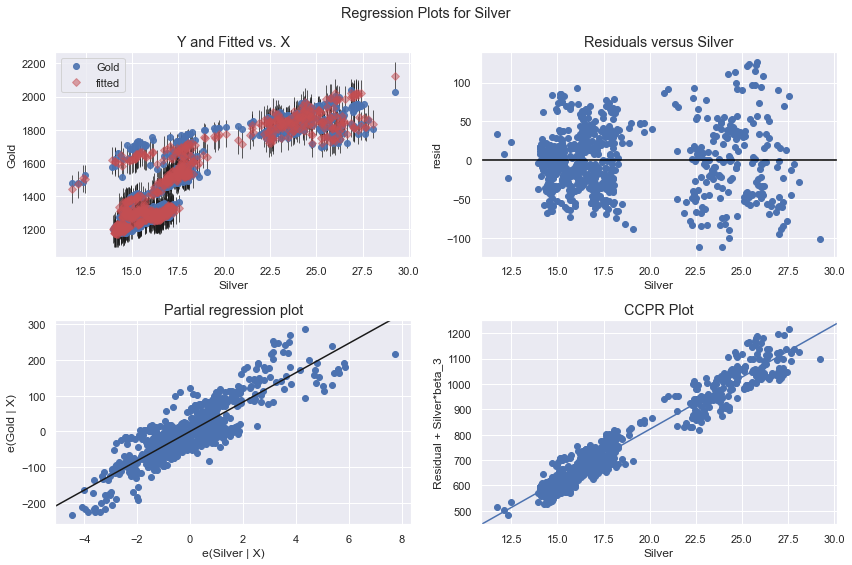

In [21]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Silver', fig=fig)

In [22]:
white_test = het_white(model.resid, model.model.exog)

labels = ['Test Statistic', 'Test Statistic P-value', 'F-Statistic', 'F-Test P-Value']

print(dict(zip(labels, white_test)))

{'Test Statistic': 257.15290237587675, 'Test Statistic P-value': 9.509917433260474e-47, 'F-Statistic': 27.656791777723583, 'F-Test P-Value': 3.049334351474875e-58}


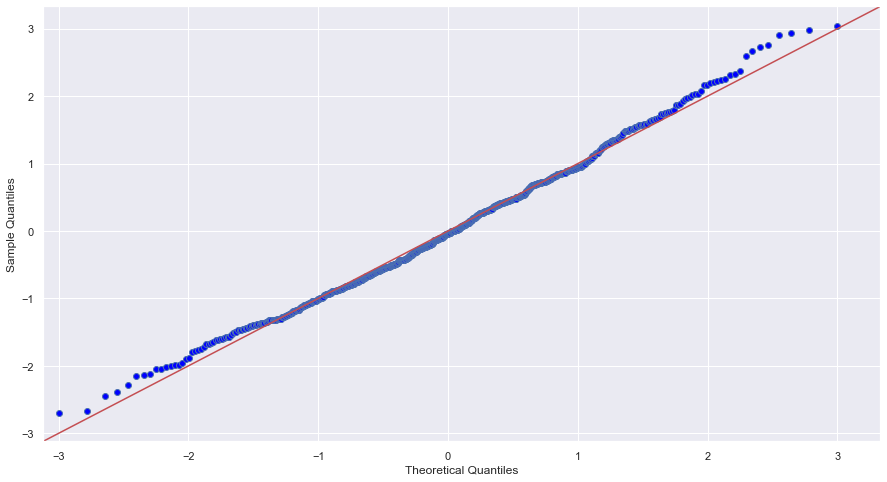

In [23]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

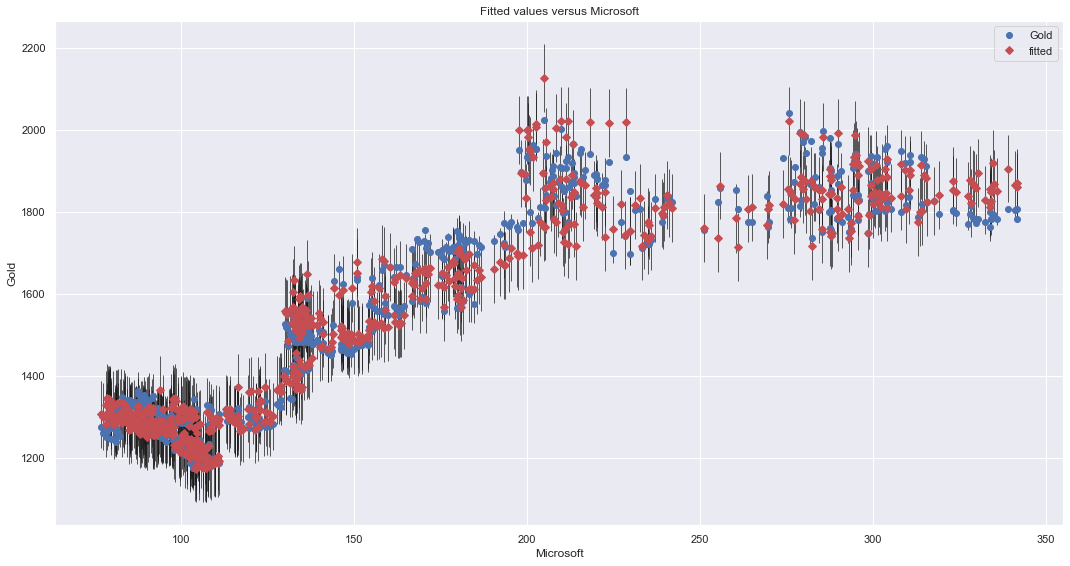

In [24]:
fig = sm.graphics.plot_fit(model, "Microsoft")
fig.tight_layout(pad=1.0)

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     6450.
Date:                Mon, 15 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:39:51   Log-Likelihood:                -3790.2
No. Observations:                 736   AIC:                             7590.
Df Residuals:                     731   BIC:                             7614.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1301.4937     13.298     97.874      0.000    1275.388    1327.600
Microsoft      3.9870      0.108     36.909      0.000       3.775       4.199
Nasdaq        -0.0955      0.003    -28.140      0.000      -0.102      -0.089
Silver        41.0659      0.898     45.726      0.000      39.303      42.829
Bond_30Y    -116.8642      3.288    -35.541      0.000    -123.320    -110.409
==============================================================================
Omnibus:                        7.565   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.726
Skew:                           0.246   Prob(JB):                       0.0210
Kurtosis:                       2.901   Cond. No.                     8.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:ylabel='Density'>

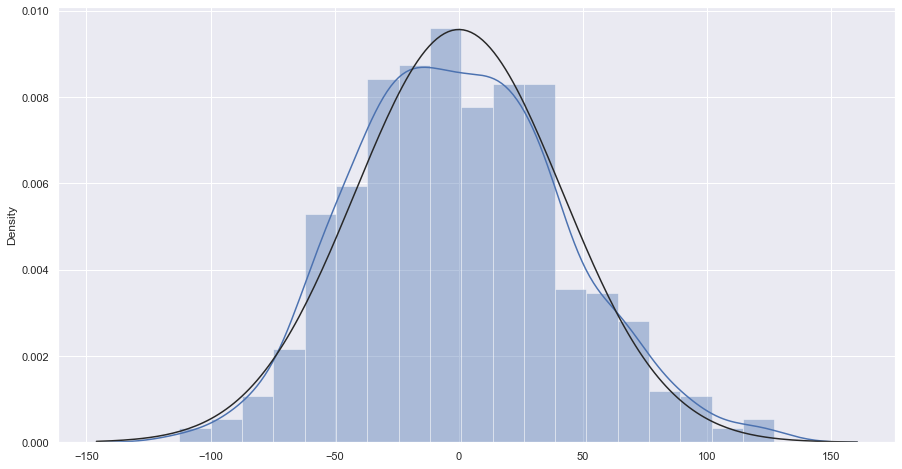

In [26]:
sns.distplot(model.resid, fit=stats.norm)

###### Log-transforming X and y does little to reduce heteroskedasticity in this particular case, due to the nature of the time series price data used in our example. Next logical steps would involve quantile regression or the use of autoregressive modeling techniques such as ARCH or ARIMA. 

###### Scale-location plot. Serves for checking the homoscedasticity. It is similar to the first diagnostic plot, but now with the residuals standardized and transformed by a square root (of the absolute value). This change transforms the task of spotting heteroskedasticity by looking into irregular vertical dispersion patterns into spotting for nonlinearities, which is somewhat simpler.

###### Under homoscedasticity, we expect the red line to be almost flat. If there are consistent nonlinear patterns, then there is evidence of heteroskedasticity.

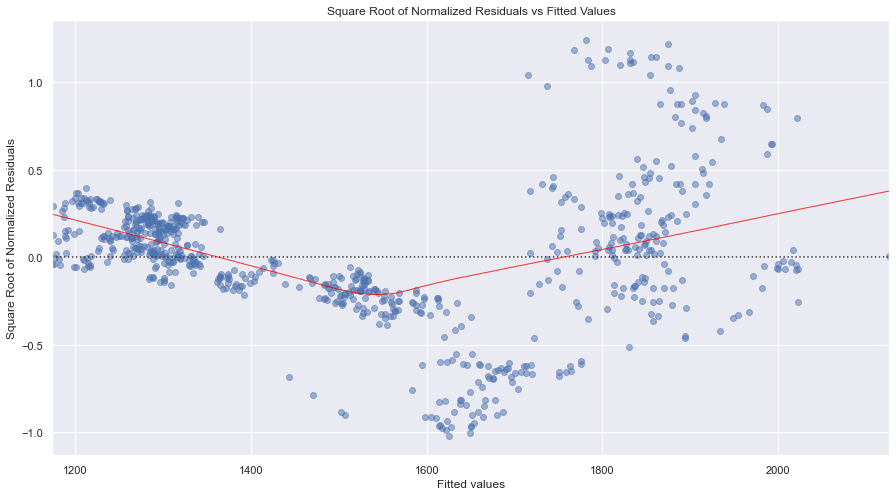

In [27]:
# model values
model_fitted_y = model.fittedvalues
# model residuals
model_residuals = model.resid
# normalized residuals
model_norm_residuals = model.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, X_train.columns[-1], data=X_train,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Square Root of Normalized Residuals vs Fitted Values')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Square Root of Normalized Residuals');

In [28]:
y_pred = model.predict(X_test)

print('  R2:   ', r2_score(y_test, y_pred).round(3), '\n'
      ' MSE:', mean_squared_error(y_test, y_pred).round(3), '\n'
      'RMSE:  ', np.sqrt(mean_squared_error(y_test, y_pred)).round(3))

r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - len(X.columns) - 1)
print("Adj. R2:", adj_r2.round(3))

  R2:    0.973 
 MSE: 1794.596 
RMSE:   42.363
Adj. R2: 0.972


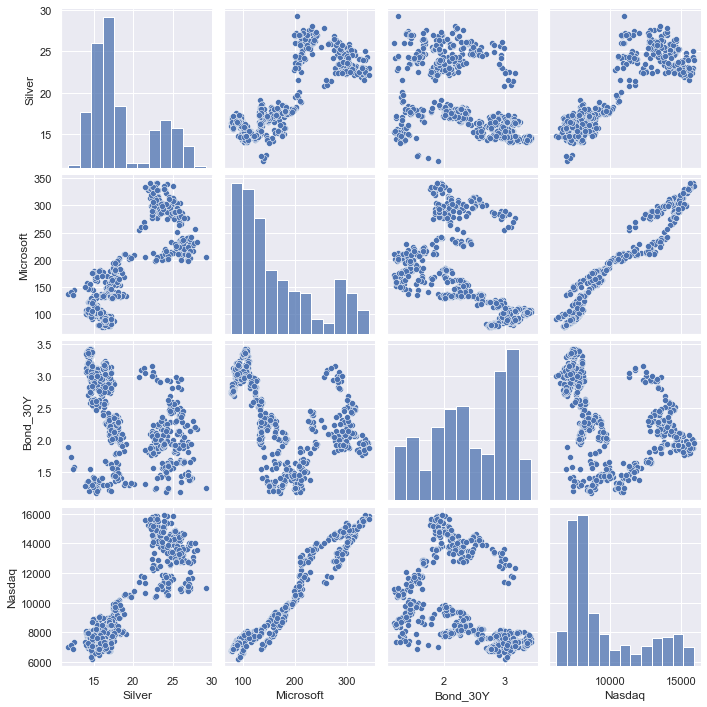

In [29]:
sns.pairplot(X_train[['Silver', 'Microsoft', 'Bond_30Y', 'Nasdaq']])

In [30]:
# Using today's (August 15th, 2022) Microsoft, Nasdaq, Silver, and Bond_30Y prices
# for predicting today's gold price

Microsoft = 293.47
Nasdaq = 13128.05
Silver = 20.210
Bond_30Y = 3.0960

Gold = 1794.30 # today's gold price to gauge how far off our model's prediction is

In [31]:
prediction = model.predict(pd.Series({'Microsoft': Microsoft,
                                      'Nasdaq': Nasdaq,
                                      'Silver': Silver,
                                      'Bond_30Y': Bond_30Y}))[0].round(2)

prediction

1685.73

In [32]:
# Our model's prediction was off by about $100

(prediction - Gold).round(2)

-108.57